In [2]:
%%capture
# Descargamos el dataset
!gdown --id 1u1MRRWnjoi3p5eWV6bOtJX4_bZ0DT4eu
!unzip balanced_dataset.zip

In [3]:
import os
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from skimage import io
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize, downscale_local_mean
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
import random
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Input,MaxPooling2D, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:

# Generador de datos
class DataGenerator(Sequence):

  # imgIDs: Lista de las ID de las imagenes a utilizar en este generator.
  # labels: Diccionario de los labels para cada ID (sin one hot encoding)
  # batch_size: Tamaño de cada batch que se genera por llamado.
  # dim: Dimensiones de las imagenes.
  # n_channels: Numero de canales de la imagen.
  # n_classes: Numero de labels distintos.
  # shuffle: Si revolver los datos o no.
  def __init__(self, imgIDs, labels, batch_size=32, dim=(160, 160), n_channels=3, n_classes=4, shuffle=True):
    self.imgIDs = imgIDs
    self.labels = labels
    self.batch_size = batch_size
    self.dim = dim
    self.n_channels = n_channels
    self.n_classes = n_classes
    self.shuffle = shuffle
    self.on_epoch_end()

  # Retorna el numero de batches del generator.
  def __len__(self):
    return int(np.floor(len(self.imgIDs) / self.batch_size))

  # Retorna un batch.
  def __getitem__(self, index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    list_IDs_temp = [self.imgIDs[k] for k in indexes]
    X, y = self.__data_generation(list_IDs_temp)

    return X, y

  # Cuando se termina un epoch, se escogen los siguientes ID.
  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgIDs))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  # Se cargan los datos a medida que se necesitan.
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    x = random.randrange(1,5,2)
    
    dim = (160, 160)
    for i, ID in enumerate(list_IDs_temp):
      temp = io.imread("./balanced_dataset_medium/data/" + ID + ".jpg")
      temp = resize(temp,dim)
      X[i,] = temp
      X[i,] = cv2.GaussianBlur(np.float32(X[i,]),(x,x),cv2.BORDER_DEFAULT)
      plt.imshow(X[i,])
      y[i] = self.labels[ID]
    X = X.astype("float32")

    return X, to_categorical(y, num_classes=self.n_classes)

In [5]:
# Observamos los datos del CSV.
dataInfo = pd.read_csv("./balanced_dataset_medium/data_info.csv")
dataInfo

,Unnamed: 0,ID,part,label,views,comments,likes,dislikes,topicID
0,0,id---2pGwkL7M_video,part1,0,3543,11.0,63.0,0.0,"['/m/04rlf', '/m/04rlf']"
1,1,id---9beuLW7Y_video,part1,0,1543,0.0,0.0,0.0,"['/m/098wr', '/m/098wr']"
2,2,id---dQKphvYc_video,part1,0,4065,4.0,13.0,0.0,"['/m/04rlf', '/m/064t9']"
3,3,id---EnHBffak_video,part1,0,7808,5.0,36.0,5.0,"['/m/0bzvm2', '/m/0bzvm2']"
4,4,id---FI9JLZRg_video,part1,0,1308,2.0,3.0,4.0,"['/m/0bzvm2', '/m/0bzvm2', '/m/0403l3g']"
...,...,...,...,...,...,...,...,...,...
19980,19980,idE2gK1mLbJKE_video,part189,3,3547841,460.0,16357.0,777.0,"['/m/04rlf', '/m/01lyv']"
19981,19981,ide2hvBdWy0X8_video,part189,3,1414097,568.0,8945.0,385.0,"['/m/04rlf', '/m/064t9', '/m/0glt670']"
19982,19982,ide2jPLqvMRwM_video,part189,3,1884647,112.0,2071.0,853.0,['/m/04rlf']
19983,19983,ide2JR9LtAic0_video,part189,3,1459441,3169.0,20779.0,386.0,"['/m/025zzc', '/m/0bzvm2', '/m/0bzvm2', '/m/02..."


In [6]:
# Tamaño de los grupos, donde se indica con proporciones.
# El resto se le asigna al grupo de test.
trainSize = 0.6
valSize = 0.2

# Generamos el diccionario de los labels, y cargamos todos los IDs en una lista.
labels = {}
data = []

for i, row in dataInfo.iterrows():
  data.append(row["ID"])
  labels[row["ID"]] = row["label"]

# Revolvemos la lista de ID.
random.Random(42).shuffle(data)

# Generamos las listas de IDs para cada grupo.
trainData = data[:int(len(data)*trainSize)]
valData = data[int(len(data)*trainSize) : int(len(data)*trainSize) + int(len(data)*valSize)]
testData = data[int(len(data)*trainSize) + int(len(data)*valSize):]

# Creamos el diccionario de listas de ID para cada grupo.
partition = {}
partition["train"] = trainData
partition["validation"] = valData
partition["test"] = testData

In [7]:
# Creamos los generadores.
trainGenerator = DataGenerator(partition["train"], labels)
valGenerator = DataGenerator(partition["validation"], labels)
testGenerator = DataGenerator(partition["test"], labels)

In [8]:
PATH = './balanced_dataset_medium/'
train_dir = os.path.join(PATH, 'data')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)


In [9]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [10]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [11]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

(32, 5, 5, 1280)


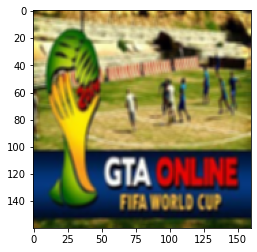

In [12]:
image_batch, label_batch = next(iter(trainGenerator))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

In [13]:
base_model.trainable = False

In [14]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [15]:
prediction_layer = tf.keras.layers.Dense(4)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [16]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [17]:
base_learning_rate = 0.0001
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [18]:
stopping = EarlyStopping(monitor='val_loss', patience=8)

In [ ]:
model.fit(trainGenerator, validation_data=valGenerator, steps_per_epoch=100, validation_steps=50, epochs = 100, callbacks=[stopping])

Epoch 1/100
374/374 [==============================] - 187s 491ms/step - loss: 8.3116 - accuracy: 0.2472 - val_loss: 7.8979 - val_accuracy: 0.2519
Epoch 2/100
 83/374 [=====>........................] - ETA: 2:17 - loss: 8.1986 - accuracy: 0.2477